### Dimensionality Reduction Solution

###### Author: Alex Sherman | alsherman@deloitte.com


##### Agenda
- Vector Space Model
- PCA
- SVD
- Latent semantic indexing (LSI/LSA)
- Latent dirichlet allocation(LDA)

In [5]:
from collections import defaultdict, Counter
from configparser import ConfigParser, ExtendedInterpolation

from IPython.core.display import display, HTML
from IPython.display import Image
from IPython.lib.display import YouTubeVideo
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import DiffMetric
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis  # conda install pyldavis
import pyLDAvis.gensim
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import spacy
from spacy.matcher import Matcher, PhraseMatcher
from spacy.lang.en.stop_words import STOP_WORDS

%matplotlib inline


config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')
GENSIM_DICTIONARY_PATH = config['NLP']['GENSIM_DICTIONARY_PATH']
GENSIM_CORPUS_PATH = config['NLP']['GENSIM_CORPUS_PATH']
CLEANED_TEXT_PATH = config['NLP']['CLEANED_TEXT_PATH']

In [12]:
with open(CLEANED_TEXT_PATH, 'r') as f:
    texts = [row.split() for row in f]

print(texts[0])

['immune_complexes', 'in', 'rheumatic', 'disease']


# Text Vectorization (gensim)

In [13]:
gensim_url = r'https://radimrehurek.com/gensim/index.html'
iframe = '<iframe src={} width=950 height=300></iframe>'.format(gensim_url)
HTML(iframe)

In [27]:
from gensim import corpora

example_text = [['computer','human', 'interface']]

# fit dictionary
# documents: Documents that used for initialization
# prune_at:  Dictionary will keep not more than prune_at words
dct = corpora.Dictionary(example_text, prune_at=2000000)  

# update dictionary with new documents - useful if text corpora doesn't fit in memory
dct.add_documents([['data','science']])

dct.doc2bow(["interface", "human", "data", "non_existent_word"], return_missing=True)

([(1, 1), (2, 1), (3, 1)], {'non_existent_word': 1})

Here we assigned a unique integer ID to all words appearing in the processed corpus with the gensim.corpora.dictionary.Dictionary class. 

This sweeps across the texts, collecting word counts and relevant statistics. In the end, we see distinct words in the processed corpus, which means each document will be represented by n numbers (ie., by a n-D vector).

In [33]:
# turn our tokenized documents into a id <-> term dictionary

dictionary = corpora.Dictionary(texts)
print(dictionary)

Dictionary(15696 unique tokens: ['diffusing', 'conditons', 'authentic', 'acute_lymphoblastic', 'rta']...)


In [34]:
# num_docs – number of documents processe
print('num docs: {}'.format(dictionary.num_docs))

# num_pos – total number of  processed words
print('num pos: {}'.format(dictionary.num_pos))

num docs: 12447
num pos: 239543


##### filter_extremes

- **no_below (int, optional)** – Keep tokens which are contained in at least no_below documents.
- **no_above (float, optional)** – Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
- **keep_n (int, optional)** – Keep only the first keep_n most frequent tokens.
- **keep_tokens (iterable of str)** – Iterable of tokens that must stay in dictionary after filtering.

In [36]:
# filter the dictionary to remove infrequent (no_below) and too frequent (no_above) terminology
dictionary.filter_extremes(no_below=.01, no_above=0.99)

In [37]:
print(dictionary.token2id)

{'diffusing': 13659, 'conditons': 2464, 'authentic': 10921, 'acute_lymphoblastic': 3392, 'rta': 12147, 'serums': 3010, 'regulating': 7801, 'kwo': 4910, 'bbingen': 6476, 'cholecystokinin': 7077, 'booster': 11542, 'elaborate': 991, 'symbolic': 4623, 'hypocalciuria': 10324, 'anastomosis': 3344, 'hemodialysis': 1515, 'intrabursal': 11395, 'simulation': 5998, 'jitter': 6379, 'narcissistic': 15116, 'predictors': 12766, 'new_jersey': 2986, 'sma': 1427, 'evans': 9863, 'vessel': 2132, 'readiographic': 5158, 'knee': 6899, 'mineral': 5885, 'tce': 11994, 'phytanic_acid': 2681, 'analysed': 4760, 'thv': 12862, 'vdrr': 11675, 'thyroid_function': 2814, 'embryologic': 14722, 'hypophysectomy': 10676, 'glomeruli': 4773, 'bought': 15336, 'buenos': 13099, 'double_blind': 3015, 'latencies': 5921, 'spanning': 14448, 'nonsurgical': 5582, 'conditioned': 9744, 'willenrand': 15618, 'phlebo': 12077, 'suprathreshold': 11720, 'orbitopathy': 14612, 'track': 6621, 'hardness': 2060, 'hfmd': 12603, 'spray': 7000, 'seve

##### doc2bow()
The function doc2bow() counts the number of occurrences of each distinct word, converts the word to its integer word id and returns the result as a bag-of-words--a sparse vector, in the form of [(word_id, word_count), ...].

For people familiar with scikit learn, doc2bow() has similar behaviors as calling transform() on CountVectorizer. doc2bow() can behave like fit_transform() as well. For more details, please look at gensim API Doc.

In [38]:
# map two documents using doc to bag of words

print('Document 0: {}'.format(texts[0]))
print(dictionary.doc2bow(texts[0]))

print('\nDocument 1: {}'.format(texts[1]))
print(dictionary.doc2bow(texts[1]))

Document 0: ['immune_complexes', 'in', 'rheumatic', 'disease']
[(0, 1), (1, 1), (2, 1), (3, 1)]

Document 1: ['gluten', 'and', 'lymphocytes', 'in', 'coeliac_disease']
[(2, 1), (4, 1), (5, 1), (6, 1), (7, 1)]


In [43]:
# notice that 'in' appears in both documents and is mapped to the same id
print(dictionary[2])

# the second number in each tuple is the count
print(dictionary.doc2bow(['in','in','in']))

in
[(2, 3)]


In [44]:
# convert tokenized documents into a document-term matrix in a sparse representation
corpus = [dictionary.doc2bow(sent) for sent in texts]
print('Sentence 1 BOW:\n {}\n'.format(corpus[0]))
print('Sentence 2 BOW:\n {}'.format(corpus[1]))

Sentence 1 BOW:
 [(0, 1), (1, 1), (2, 1), (3, 1)]

Sentence 2 BOW:
 [(2, 1), (4, 1), (5, 1), (6, 1), (7, 1)]


In [45]:
# initialize a tfidf model (similary to TfidfTransformer from sklearn)
tfidf = models.TfidfModel(corpus)
print('TFIDF for sentent 0:\n {}\n'.format(tfidf[corpus[0]]))
print('TFIDF for sentent 1:\n {}'.format(tfidf[corpus[1]]))

TFIDF for sentent 0:
 [(0, 0.03909018618396727), (1, 0.7357717406121994), (2, 0.06241894645938989), (3, 0.6732130258569696)]

TFIDF for sentent 1:
 [(2, 0.060961987214653596), (4, 0.07292108431674547), (5, 0.5237885112349946), (6, 0.6803042477217273), (7, 0.5037835622635114)]


In [46]:
# convert the entire corpus to tfidf
tfidf_vect = [tfidf[i] for i in corpus]

In [47]:
# save the dictionary - we will use it again in different lessons
print('GENSIM_DICTIONARY_PATH: {}'.format(GENSIM_DICTIONARY_PATH))
dictionary.save(GENSIM_DICTIONARY_PATH)  

GENSIM_DICTIONARY_PATH: C:\Users\alsherman\Desktop\NLP\nlp_practicum_health\raw_data/gensim/pubmed_dict.dict


In [48]:
# store to disk - we will use it again in different notebooks
print('GENSIM_CORPUS_PATH: {}'.format(GENSIM_CORPUS_PATH))
corpora.MmCorpus.serialize(GENSIM_CORPUS_PATH, corpus)

GENSIM_CORPUS_PATH: C:\Users\alsherman\Desktop\NLP\nlp_practicum_health\raw_data/gensim/pubmed.mm


##### Limitations of the vector space model:

We generally do not want to feed a large number of features directly into a machine learning algorithm because:
- They are expensive to store.
- They slow down computations (e.g. in algorithms like k nearest neighbors)
- Large samples are required to avoid overfitting.


**Synonymy:** the characteristic of language to have several terms that mean essentially the same thing
-  In the SAS technical support data set the terms “frozen” and “hangs” often refer to the same situation where the program has reached a point where nothing is happening and yet the user cannot continue working

**Polysemy:** is the tendency for the same term to mean different things in different contexts.
- The term “monitor” in technical support data is a good example of this. At times it refers to the computer screen, sometimes it refers to a piece of software that displays a graphical result and still other times it refers to the user “watching” or “observing” an event

**Term dependence:** refers to the tendency for certain terms to be highly correlated with one another. This problem is not unique to text but also occurs with most other sets of data as well. 
- The terms “error” and “message” are strongly correlated in the technical support collection. When one occurs, the other also tends to occur. A pair of documents, each containing these two terms, may have their similarity overrated in this case

SOURCE: 
- https://davidrosenberg.github.io/ml2015/docs/13.Lab.PCA-SVD-LDA.pdf
- ftp://ftp.sas.com/techsup/download/EMiner/TamingTextwiththeSVD.pdf

## Dimensionality Reduction and Semantic Transformations

### Principal Component Analysis (PCA)

The sheer size of data in the modern age is not only a challenge for computer hardware but also a main bottleneck for the performance of many machine learning algorithms. The main goal of a PCA analysis is to identify patterns in data; PCA aims to detect the correlation between variables. If a strong correlation between variables exists, the attempt to reduce the dimensionality only makes sense. In a nutshell, this is what PCA is all about: Finding the directions of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace while retaining most of the information.

- Principal Component Analysis (PCA) is a dimension-reduction tool that can be used to reduce a large set of variables to a small set that still contains most of the information in the large set.
- Principal component analysis (PCA) is a mathematical procedure that transforms a number of (possibly) correlated variables into a (smaller) number of uncorrelated variables called principal components. 
- PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance
- The first principal component accounts for as much of the variability in the data as possible, and each succeeding component accounts for as much of the remaining variability as possible.

SOURCE: 
- http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
- ftp://statgen.ncsu.edu/pub/thorne/molevoclass/AtchleyOct19.pdf

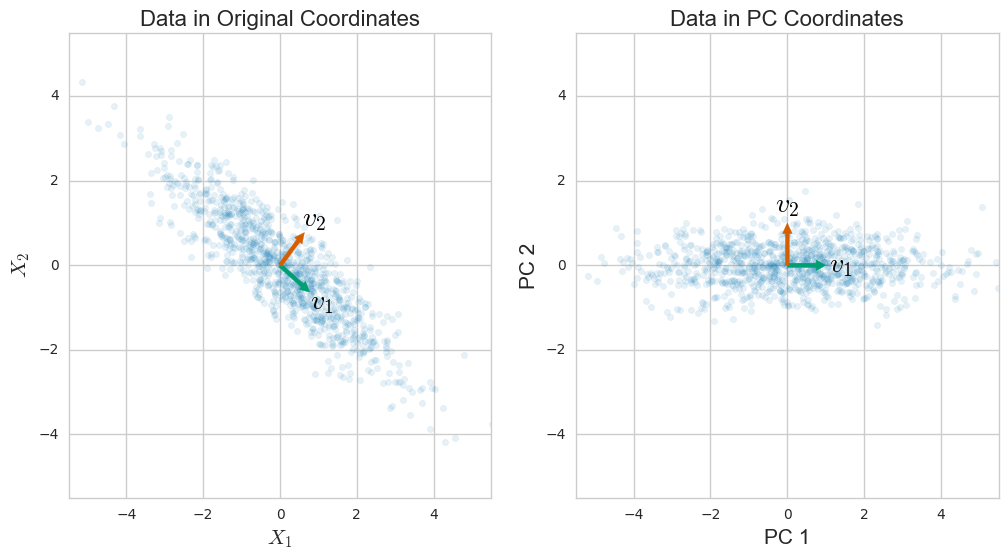

In [49]:
# PCA
# SOURCE: https://intoli.com/blog/pca-and-svd/
Image("../../raw_data/images/pca.png", width=700)

In [50]:
X_df = pd.DataFrame([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
X_df

,0,1
0,-1,-1
1,-2,-1
2,-3,-2
3,1,1
4,2,1
5,3,2


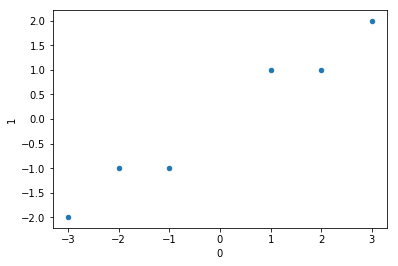

In [51]:
X_df.plot.scatter(x=0, y=1)

In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
fit_pca = pca.fit_transform(X_df)

# print out the transformed matrix
pca_df = pd.DataFrame(fit_pca, columns=['component 1','component 2'])
pca_df

,component 1,component 2
0,1.383406,0.293579
1,2.221898,-0.251335
2,3.605304,0.042244
3,-1.383406,-0.293579
4,-2.221898,0.251335
5,-3.605304,-0.042244


(-2, 2)

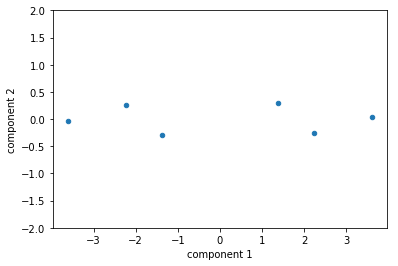

In [53]:
# plot the prinipal components
pca_df.plot.scatter(x='component 1', y='component 2')

# increase range of y-axis
plt.ylim(-2,2)

The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the “core” of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

In [54]:
print('Singular values: {}'.format(pca.singular_values_.round(2)))

# Singular Values are the l2 norm of each component
# e.g. np.sqrt(sum([i**2 for i in pca_df['component 1']]))
print('Singluar Value 1: {}'.format(np.linalg.norm(pca_df['component 1'], ord=2).round(2)))
print('Singluar Value 2: {}'.format(np.linalg.norm(pca_df['component 2'], ord=2).round(2)))

print('\nExplained variance ratio: {}'.format(pca.explained_variance_ratio_))

Singular values: [6.3  0.55]
Singluar Value 1: 6.3
Singluar Value 2: 0.55

Explained variance ratio: [0.99244289 0.00755711]


In [55]:
print('Components:\n {}'.format(pca.components_.round(2)))

Components:
 [[-0.84 -0.54]
 [ 0.54 -0.84]]


##### Recreate PCA through SVD

In [56]:
# transpose X_df by using .T
X_df.T

,0,1,2,3,4,5
0,-1,-2,-3,1,2,3
1,-1,-1,-2,1,1,2


In [57]:
# recreate PCA using SVD (we will explain this calculation in the next section)
u,s,vt = np.linalg.svd(X_df)
print("singular values =\n", np.round(s, decimals=2), "\n")
print("components =\n", np.round(vt, decimals=2), "\n")

# pca
pd.DataFrame(X_df.dot(vt))

singular values =
 [6.3  0.55] 

components =
 [[ 0.84  0.54]
 [ 0.54 -0.84]] 



,0,1
0,-1.383406,0.293579
1,-2.221898,-0.251335
2,-3.605304,0.042244
3,1.383406,-0.293579
4,2.221898,0.251335
5,3.605304,-0.042244


### Singular Value Decomposition

In linear algebra, the singular-value decomposition (SVD) is a factorization of a real or complex matrix.

Let A be an m × n term-document frequency matrix with rank r, r ≤ n. Without loss of generality let m ≥ n hold so that there are more terms than documents. The singular value decomposition of A can be stated succinctly as A = U*Σ*VT,

- U is an m × r orthogonal matrix whose columns make up the left singular vectors
- Σ is an r × r dimensional diagonal matrix whose diagonal elements are termed singular values
- V is an r × northogonal matrix whose columns form the right singular vectors of A.

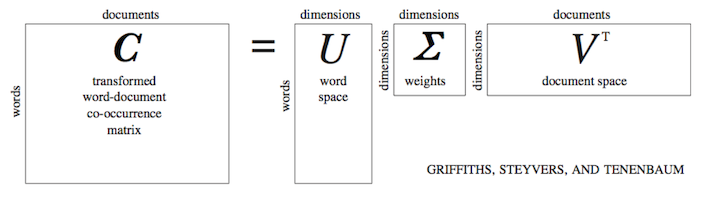

In [58]:
# SVD
Image("../../raw_data/images/svd_graph.png", width=700, height=700)

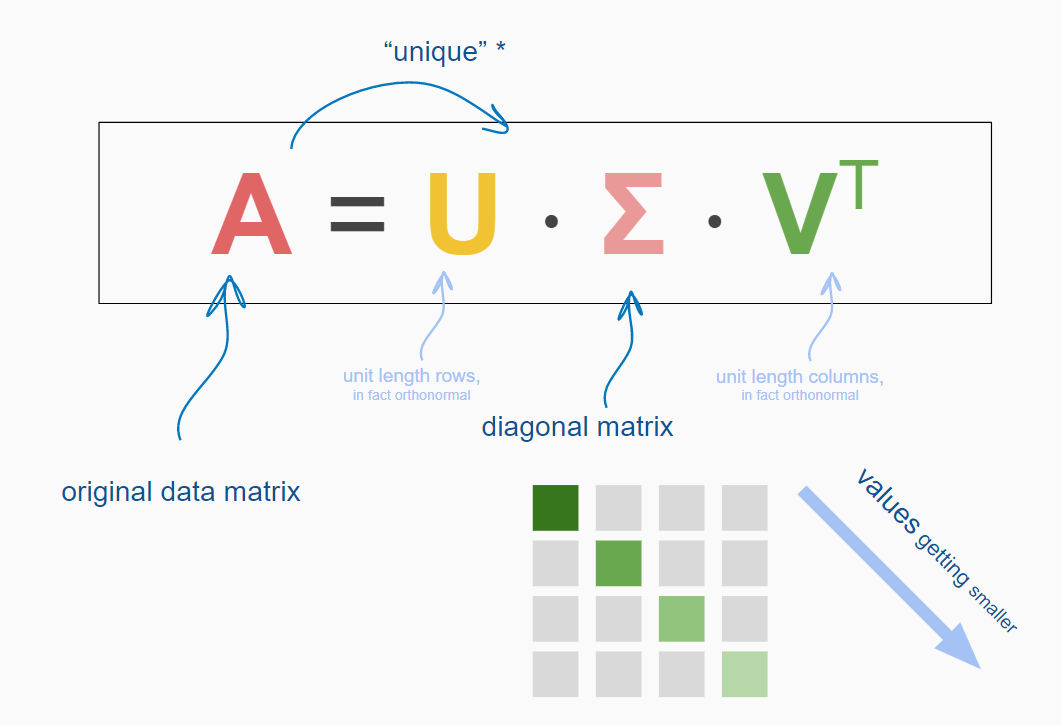

In [59]:
# SVD
Image("../../raw_data/images/svd3.png", width=400)

##### Reduced SVD

The SVD comes in two forms, a full SVD, and a reduced SVD. In NLP, we tend to focus on the reduced SVD, using SVD for dimensionality reduction.

SVD can be viewed as a sum of rank one matrices.The matrix A can then be approximated by choosing any k ≤ r. This generates a rank k matrix, Ak, that is the best rank-k approximation to A in terms of least-squares best fit

SOURCE: ftp://ftp.sas.com/techsup/download/EMiner/TamingTextwiththeSVD.pdf

"Singlular Value Decomposition (SVD) allows us to reduce the dimensionality of a matrix. Instead of analyzing a full document-term matrix with all documents and all terms, we can reduce the matrix into a lower rank representation. In this, we combine the meaning of terms by compressing the number of columns.

To reduce the size of our matrix without losing much quality, we can perform a low-rank approximation on matrix C. This is done by keeping the top k values of Σ and setting the rest to zero, where k is the new rank. Since Σ contains eigenvalues in descending order, and the effect of small eigenvalues on matrix products is small, the zeroing of the lowest values will leave the reduced matrix C' approximate to C. How to retrieve the most optimal k is not an easy task, since we want k top large enough to include as much variety as possible from our original matrix C, but small enough to exclude sampling errors and redundancy. To do this in a formal way, the Frobenius norm can be applied to measure the discrepancy between C and C_k. A less extensive way is just to try out a couple of different k-values and see what generates the best results."

SOURCE: https://simonpaarlberg.com/post/latent-semantic-analyses/

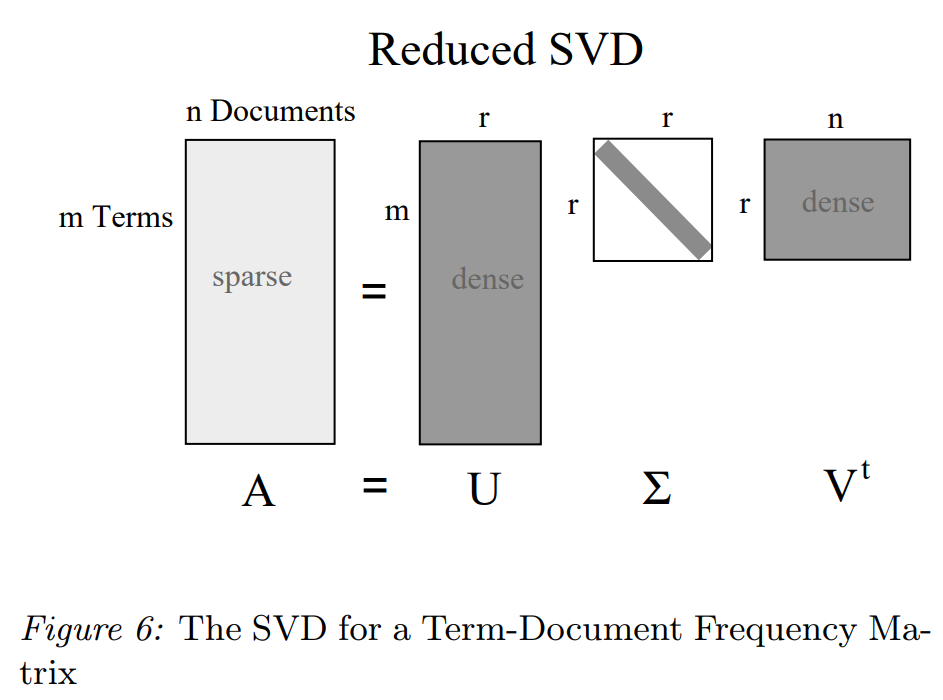

In [60]:
# reduced SVD
Image("../../raw_data/images/reduced_svd.png", width=500, height=700)

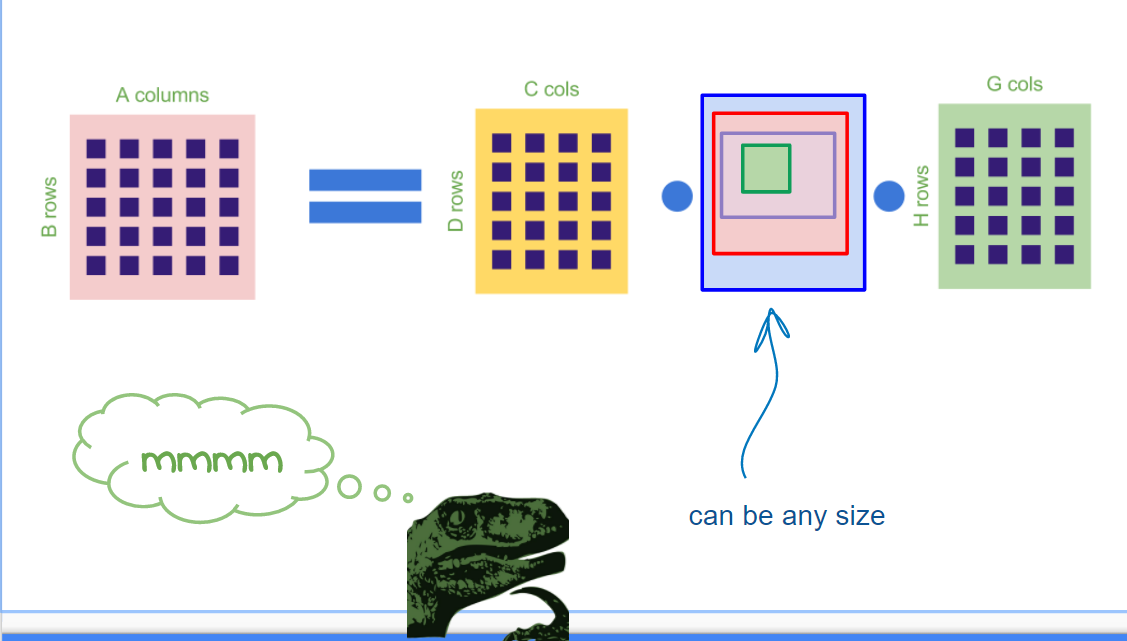

In [61]:
# SVD
Image("../../raw_data/images/svd2.png", width=700)

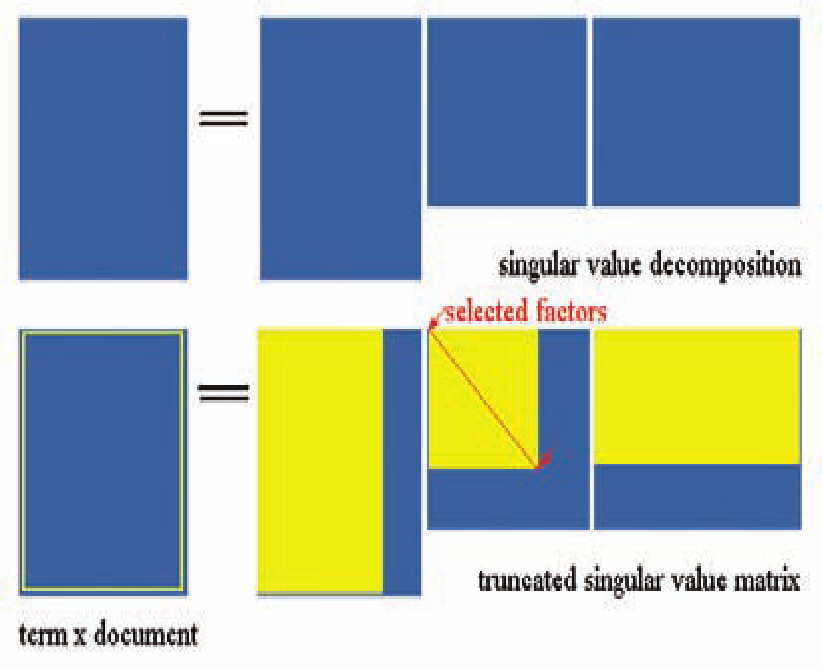

In [62]:
# Truncated SVD
# SOURCE: https://www.researchgate.net/figure/Singular-value-decomposition-SVD-and-a-truncated-SVD-matrix_fig1_227060873
Image("../../raw_data/images/truncated_svd.png", width=500)

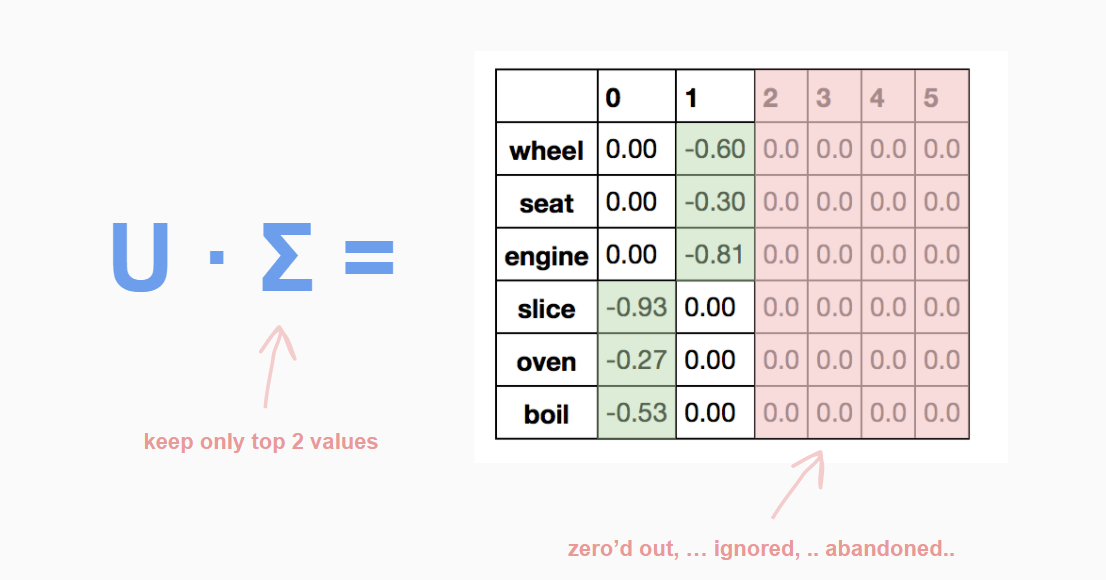

In [63]:
# SVD
Image("../../raw_data/images/svd4.png", width=700)

##### SVD approximation equation
Equation 1 implies that one can get a rough approximation to A by taking the product of the first singular value with the matrix formed from the outer product of the first column of U with the first column of V . The matrix formed, A1, will be m × n but will be of only rank one. Of all possible matrices, B, of rank one, ||A − B||2 will be smallest when B = A1 holds. One can improve the approximation by forming the product of the second singular value with the outer product of the second columns of U and V , and then adding this result to A1. The resultant matrix, A2, will be the the best rank-two approximation to A. The approximations can be successively improved by repeating the process until k = r holds and the original matrix is produced.

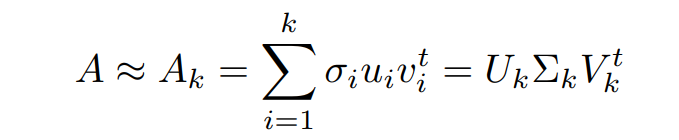

In [64]:
# reduced SVD equation
Image("../../raw_data/images/svd_truncated_equation.png", width=500, height=700)

##### Coursera Course on SVD

SOURCE: https://www.coursera.org/learn/matrix-factorization/lecture/K5NBy/singular-value-decomposition

### SVD Example

In [65]:
import numpy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [66]:
print(texts[0])

['immune_complexes', 'in', 'rheumatic', 'disease']


In [67]:
# combine tokens into sentences
svd_data = [' '.join(text) for text in texts[0:8]]

# create a document term matrix of the token counts
vect = CountVectorizer(max_features=10, stop_words='english')
dtm = vect.fit_transform(svd_data)
vocab = vect.get_feature_names()
df = pd.DataFrame(dtm.toarray(), columns=vocab)
df

,disease,evidence,including,increased,intent,latency,lymphocytes,manifestations,nervousness,patients
0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,1,1,0
4,1,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,1
6,1,0,0,0,0,1,0,0,0,0
7,1,1,0,0,1,0,0,0,0,1


In [68]:
# decompose the matrix using SVD
U, s, VT = numpy.linalg.svd(df, full_matrices=False)
S = numpy.diag(s)

In [69]:
# what are U, S and V
print("U =\n", numpy.round(U, decimals=2), "\n")
print("S =\n", numpy.round(S, decimals=2), "\n")
print("V^T =\n", numpy.round(VT, decimals=2), "\n")

U =
 [[ 0.25  0.18 -0.28 -0.    0.24 -0.32 -0.05 -0.81]
 [ 0.   -0.    0.   -1.    0.   -0.    0.    0.  ]
 [ 0.25  0.18 -0.28 -0.    0.24 -0.32 -0.68  0.45]
 [ 0.61 -0.79 -0.03  0.    0.03  0.09 -0.   -0.  ]
 [ 0.25  0.18 -0.28  0.    0.24 -0.32  0.73  0.36]
 [ 0.34  0.36  0.07 -0.    0.45  0.74  0.    0.  ]
 [ 0.28  0.24 -0.52 -0.   -0.73  0.26  0.    0.  ]
 [ 0.5   0.32  0.7   0.   -0.29 -0.27  0.   -0.  ]] 

S =
 [[3.14 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.94 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.48 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.87 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.67 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]] 

V^T =
 [[ 0.79  0.35  0.19  0.19  0.16  0.09  0.    0.19  0.19  0.27]
 [ 0.34 -0.24 -0.41 -0.41  0.16  0.13 -0.   -0.41 -0.41  0.35]
 [-0.41  0.45 -0.02 -0.02  0.47 -0.35  0.   -0.02 -0.02  0.52]
 [ 0.   -0.   -0.    0.    0.   -0. 

In [70]:
# U is othonormal
# These vectors are orthogonal to one another; form a basis for the reduced space

# each vector is normalized (unit vector)
# multiply by itself returns 1
col1 = np.array([i[0] for i in U])
print(col1.dot(col1))

col2 = np.array([i[1] for i in U])
print(col2.dot(col2))

# and each vector is orthogonal to the other vectors
# multiply different vectors returns 0
col1.dot(col2)

1.0000000000000007
0.9999999999999998


-8.326672684688674e-17

In [71]:
# rebuild A2 from U.S.V
A2 = numpy.dot(U, numpy.dot(S, VT))
print("A2 =\n", numpy.round(A2, decimals=2))

A2 =
 [[ 1. -0. -0. -0.  0.  0.  0. -0. -0.  0.]
 [-0.  0.  0.  0.  0. -0.  1.  0.  0. -0.]
 [ 1. -0. -0. -0.  0.  0.  0. -0. -0.  0.]
 [ 1.  1.  1.  1.  0. -0.  0.  1.  1. -0.]
 [ 1. -0. -0. -0.  0.  0. -0. -0. -0.  0.]
 [ 1.  0.  0. -0. -0.  0.  0.  0.  0.  1.]
 [ 1. -0.  0.  0. -0.  1.  0.  0.  0.  0.]
 [ 1.  1.  0. -0.  1. -0. -0. -0. -0.  1.]]


In [72]:
# S_reduced is the same as S but with only the top n elements kept
S_reduced = numpy.zeros_like(S)

# only keep top few eigenvalues
eigen_num = 3
S_reduced[:eigen_num, :eigen_num] = S[:eigen_num,:eigen_num]

# show S_rediced which has less info than original S
print("S_reduced =\n", numpy.round(S_reduced, decimals=2))

S_reduced =
 [[3.14 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.94 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.48 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [73]:
# what is the document matrix now?
S_reduced_VT = numpy.dot(S_reduced, VT)
print("S_reduced_VT = \n", numpy.round(S_reduced_VT, decimals=2))

S_reduced_VT = 
 [[ 2.48  1.11  0.61  0.61  0.5   0.28  0.    0.61  0.61  0.83]
 [ 0.67 -0.47 -0.79 -0.79  0.32  0.24 -0.   -0.79 -0.79  0.68]
 [-0.61  0.67 -0.03 -0.03  0.7  -0.52  0.   -0.03 -0.03  0.78]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]


In [74]:
# each Singular Value vector is a linear combination of original words
U_S_reduced = numpy.dot(U, S_reduced)
df = pd.DataFrame(numpy.round(U_S_reduced, decimals=2), index=vocab[0:8])

# show colour coded so it is easier to see significant word contributions to a topic
df.style.background_gradient(cmap=plt.get_cmap('Blues'))

,0,1,2,3,4,5,6,7
disease,0.79,0.34,-0.41,0,0,0,0,0
evidence,0,-0,0,0,0,0,0,0
including,0.79,0.34,-0.41,0,0,0,0,0
increased,1.92,-1.52,-0.05,0,0,0,0,0
intent,0.79,0.34,-0.41,0,0,0,0,0
latency,1.05,0.69,0.11,0,0,0,0,0
lymphocytes,0.88,0.47,-0.76,0,0,0,0,0
manifestations,1.56,0.62,1.04,0,0,0,0,0


##### When is the SVD Technique Appropriate?
For most Text Mining problems, the SVD will be entirely appropriate to use. Without a data reduction technique, there will be more variables (terms) available than one can use in a data mining model. Some method must be applied to select an appropriate set from which a text mining solution can be built. Unlike term elimination, the SVD technique allows one to derive significantly fewer variables from the original variables. There are some drawbacks to using the SVD, however. Computationally, the SVD is fairly resource intensive and requires a large amount of RAM. The user must have access to these resources in order for the decomposition to be obtained.

##### How Many Dimensions Should be Used?
The choice for the number of dimensions k to use can be a crucial aspect of many text mining solutions. With too few dimensions, the model will fail to explain prominent relationships in the text. On the other hand, using too many dimensions will add unnecessary noise to the model and make training an effective model nearly impossible. In practice, there is an upper bound of at most a few hundred dimensions from which to build a model. So the user should not need to consider more than this

### SVD in comparision to PCA
Using the below image displaying several documents that contain only two terms (A&B)

**SVD:** draw a line through the points in such a way that the sum of the distances from each point to the line is minimized. The documents can then be perpendicularly projected onto this new line. The circles indicate the locations of the projected documents. This line and the new locations for the documents, can be obtained by using the SVD

**PCA:** Spread the points out as much as possible on this new line to maximize the variance of the points that are projected onto the line. This line is formed by performing Principal Component Analysis

Although based on equivalent procedures, since PCA and TM’s SVD approach operate on different data, they do not produce the same results. Depending on whether the raw data is used or the covariance matrix is used, different vectors will be found as basis vectors for the reduced space

While the PCA component maximizes the variance, the SVD finds the best fitting line in the least-squares sense. The SVD line is affected by the dispersement of Word_B when Word_A occurs between 0 and 10 times while the PCA line is not influenced by this secondary variation. Depending on the nature of the data, these two lines may or may not be fairly close to one another. 

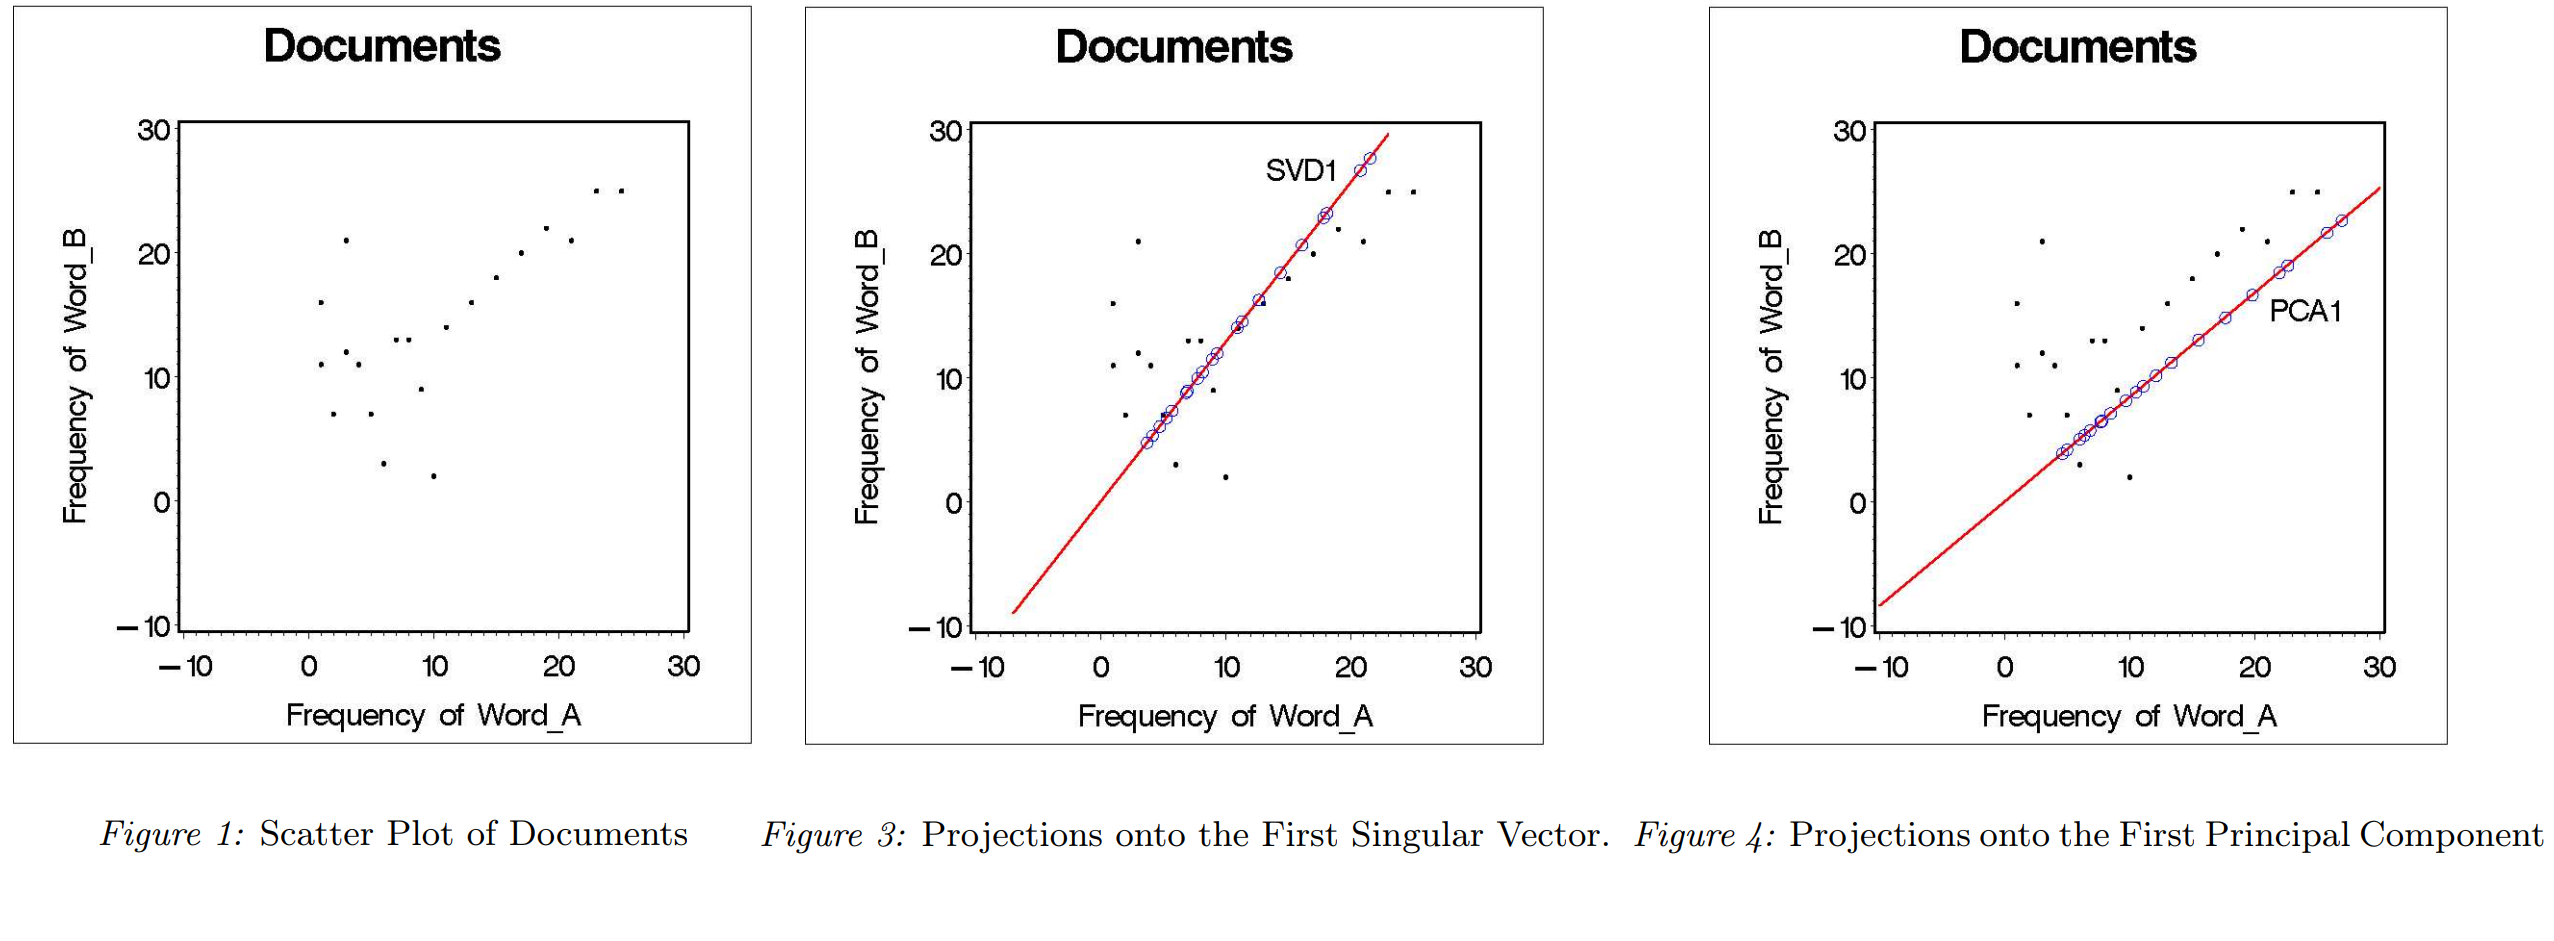

In [75]:
# SVD vs PCA
Image("../../raw_data/images/svd_vs_pca.png", width=1000)

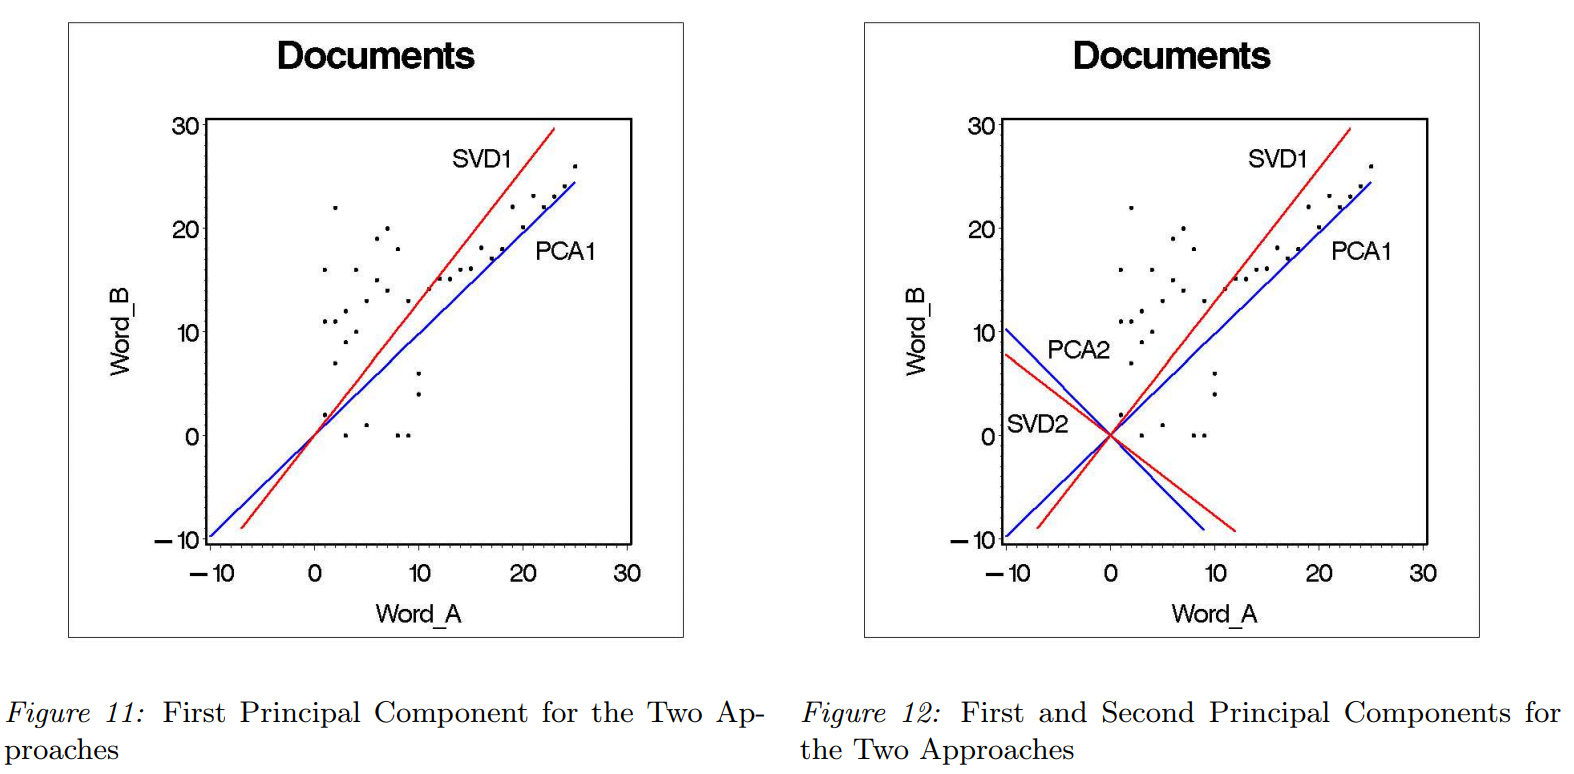

In [76]:
# SVD vs PCA
Image("../../raw_data/images/svd_vs_pca2.png", width=700)

### Latent Semantic Indexing (LSI)
Latent semantic indexing (LSI) is an indexing and retrieval method that uses a mathematical technique called singular value decomposition (SVD) to identify patterns in the relationships between the terms and concepts contained in an unstructured collection of text. LSI is based on the principle that words that are used in the same contexts tend to have similar meanings. A key feature of LSI is its ability to extract the conceptual content of a body of text by establishing associations between those terms that occur in similar contexts.

The method, also called latent semantic analysis (LSA), uncovers the underlying latent semantic structure in the usage of words in a body of text and how it can be used to extract the meaning of the text in response to user queries, commonly referred to as concept searches. Queries, or concept searches, against a set of documents that have undergone LSI will return results that are conceptually similar in meaning to the search criteria even if the results don’t share a specific word or words with the search criteria.

##### Overview
LSA can use a term-document matrix which describes the occurrences of terms in documents; it is a sparse matrix whose rows correspond to terms and whose columns correspond to documents. A typical example of the weighting of the elements of the matrix is tf-idf (term frequency–inverse document frequency): the weight of an element of the matrix is proportional to the number of times the terms appear in each document, where rare terms are upweighted to reflect their relative importance.

This matrix is also common to standard semantic models, though it is not necessarily explicitly expressed as a matrix, since the mathematical properties of matrices are not always used.

##### Rank Lowering
After the construction of the occurrence matrix, LSA finds a low-rank approximation to the term-document matrix. There could be various reasons for these approximations:

**The original term-document matrix is presumed too large for the computing resources:** in this case, the approximated low rank matrix is interpreted as an approximation (a "least and necessary evil").
**The original term-document matrix is presumed noisy:** for example, anecdotal instances of terms are to be eliminated. From this point of view, the approximated matrix is interpreted as a de-noisified matrix (a better matrix than the original).
The original term-document matrix is presumed overly sparse relative to the "true" term-document matrix. That is, the original matrix lists only the words actually in each document, whereas we might be interested in all words related to each document—generally a much larger set due to synonymy.
The consequence of the rank lowering is that some dimensions are combined and depend on more than one term:

{(car), (truck), (flower)} --> {(1.3452 * car + 0.2828 * truck), (flower)}

This mitigates the problem of identifying synonymy, as the rank lowering is expected to merge the dimensions associated with terms that have similar meanings. It also mitigates the problem with polysemy, since components of polysemous words that point in the "right" direction are added to the components of words that share a similar meaning. Conversely, components that point in other directions tend to either simply cancel out, or, at worst, to be smaller than components in the directions corresponding to the intended sense.


##### Use Cases
- Compare the documents in the low-dimensional space (data clustering, document classification).
- Find similar documents across languages, after analyzing a base set of translated documents (cross language retrieval).
- Find relations between terms (synonymy and polysemy).
- Given a query of terms, translate it into the low-dimensional space, and find matching documents (information retrieval).
- Find the best similarity between small groups of terms, in a semantic way (i.e. in a context of a knowledge corpus), as for example in multi choice questions MCQ answering model.
- Expand the feature space of machine learning / text mining systems 
- Analyze word association in text corpus 

Synonymy and polysemy are fundamental problems in natural language processing:
* **Synonymy** is the phenomenon where different words describe the same idea. Thus, a query in a search engine may fail to retrieve a relevant document that does not contain the words which appeared in the query. For example, a search for "doctors" may not return a document containing the word "physicians", even though the words have the same meaning.

* **Polysemy** is the phenomenon where the same word has multiple meanings. So a search may retrieve irrelevant documents containing the desired words in the wrong meaning. For example, a botanist and a computer scientist looking for the word "tree" probably desire different sets of documents.

##### Limitations
LSA cannot capture polysemy (i.e., multiple meanings of a word) because each occurrence of a word is treated as having the same meaning due to the word being represented as a single point in space. For example, the occurrence of "chair" in a document containing "The Chair of the Board" and in a separate document containing "the chair maker" are considered the same. The behavior results in the vector representation being an average of all the word's different meanings in the corpus, which can make it difficult for comparison. However, the effect is often lessened due to words having a predominant sense throughout a corpus (i.e. not all meanings are equally likely).

SOURCE: https://en.wikipedia.org/wiki/Latent_semantic_analysis#cite_note-38

In [77]:
from sklearn.decomposition import TruncatedSVD

In [78]:
svd_data[0]

'immune_complexes in rheumatic disease'

In [79]:
# vectorize the text with TFIDF
vect = TfidfVectorizer(max_features=10)
fit_vect = vect.fit_transform(svd_data)
pd.DataFrame(fit_vect.toarray(), columns=vect.get_feature_names())

,and,disease,evidence,in,of,patients,the,they,to,with
0,0.000000,0.622455,0.000000,0.782655,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.748789,0.000000,0.000000,0.662808,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.280764,0.197655,0.000000,0.000000,0.248525,0.000000,0.640445,0.000000,0.000000,0.640445
3,0.183248,0.129004,0.242203,0.000000,0.324412,0.000000,0.627003,0.577995,0.242203,0.000000
4,0.000000,0.189713,0.000000,0.238539,0.238539,0.000000,0.922067,0.000000,0.000000,0.000000
5,0.000000,0.311413,0.000000,0.391561,0.391561,0.584670,0.000000,0.000000,0.000000,0.504523
6,0.498378,0.350852,0.000000,0.441151,0.000000,0.000000,0.000000,0.000000,0.658717,0.000000
7,0.000000,0.174667,0.327934,0.000000,0.658863,0.327934,0.000000,0.000000,0.000000,0.565960


Dimensionality reduction using TruncatedSVD (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.

In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

SOURCE: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [80]:
tsvd = TruncatedSVD(n_components=2)
tsvd.fit_transform(fit_vect)

array([[ 0.58993214,  0.58346403],
       [ 0.52773497,  0.67132692],
       [ 0.77467273, -0.42564204],
       [ 0.63876712, -0.34289944],
       [ 0.6881118 , -0.29925978],
       [ 0.73156833, -0.05814679],
       [ 0.59060424,  0.62931669],
       [ 0.61090209, -0.44677419]])

# LDA/NMF

The normal distribution is a probability distribution over all the real numbers. It is described by a mean and a variance. The mean is the expected value of this distribution, and the variance tells us how much we can expect samples to deviate from the mean. If the variance is very high, then you’re going to see values that are both much smaller than the mean and much larger than the mean. If the variance is small, then the samples will be very close to the mean. If the variance goes close to zero, all samples will be almost exactly at the mean.

The dirichlet distribution is a probability distribution as well - but it is not sampling from the space of real numbers. Instead it is sampling over a probability simplex.

And what is a probability simplex? It’s a bunch of numbers that add up to 1. For example:

- (0.6, 0.4)
- (0.1, 0.1, 0.8)
- (0.05, 0.2, 0.15, 0.1, 0.3, 0.2)

These numbers represent probabilities over K distinct categories. In the above examples, K is 2, 3, and 6 respectively. That’s why they are also called categorical distributions.

When we are dealing with categorical distributions and we have some uncertainty over what that distribution is, simplest way to represent that uncertainty as a probability distribution is the Dirichlet.

SOURCE: 
- [What is an intuitive explanation of the Dirichlet distribution?](https://www.quora.com/What-is-an-intuitive-explanation-of-the-Dirichlet-distribution)
- [VIDEO: Digging into the Dirichlet Distribution](https://www.hakkalabs.co/articles/the-dirichlet-distribution)
- [Introduction to Latent Dirichlet Allocation:](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/)

In [81]:
from gensim.models.ldamodel import LdaModel

In [82]:
ldamodel = LdaModel(
      tfidf_vect
    , num_topics=10
    , id2word=dictionary
    , passes=200
)

In [83]:
ldamodel.print_topics(num_topics=10, num_words=5)

[(0, '0.014*"the" + 0.009*"is" + 0.009*"to" + 0.008*"of" + 0.008*"in"'),
 (1,
  '0.005*"parkinson_disease" + 0.003*"processes" + 0.003*"trophoblastic_disease" + 0.003*"oral" + 0.003*"rheumatoid_arthritis"'),
 (2,
  '0.005*"basedow_disease" + 0.004*"pituitary" + 0.004*"crohn_disease" + 0.004*"cushing_disease" + 0.003*"author_transl"'),
 (3,
  '0.004*"stages" + 0.003*"assessment" + 0.003*"hyaline_membrane" + 0.003*"high_density" + 0.003*"serious"'),
 (4,
  '0.006*"pregnancy" + 0.004*"occlusive" + 0.004*"pulmonary" + 0.004*"dogs" + 0.004*"inoculation"'),
 (5,
  '0.004*"bone" + 0.004*"leukemia" + 0.003*"vaccines" + 0.003*"in" + 0.003*"alpha_hydroxyvitamin"'),
 (6,
  '0.003*"re" + 0.003*"celiac_disease" + 0.003*"in" + 0.003*"absorption" + 0.003*"aleutian_disease"'),
 (7,
  '0.004*"exercise" + 0.004*"zinc" + 0.004*"coronary_heart" + 0.004*"blood" + 0.004*"diabetes_mellitus"'),
 (8,
  '0.012*"virus" + 0.007*"with" + 0.006*"the" + 0.006*"and" + 0.006*"foot_and_mouth"'),
 (9,
  '0.010*"the" + 0

### pyLDAvis
pyLDAvis is a python libarary for interactive topic model visualization. It is a port of the fabulous R package by Carson Sievert and Kenny Shirley. They did the hard work of crafting an effective visualization. pyLDAvis makes it easy to use the visualiziation from Python and, in particualr, IPython notebooks. To learn more about the method behind the visualization I suggest reading the original paper explaining it.

- **conda install pyldavis**


In [84]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, mds='tsne')

C:\Users\alsherman\AppData\Local\Continuum\anaconda3\envs\guild\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
0      42.224022        1       1  -30.931601   85.027443
9      20.320467        1       2  197.678802 -144.748901
8      12.704409        1       3 -175.225311 -141.027481
3       4.398987        1       4 -204.428955   55.112354
6       4.184846        1       5  285.043274   62.907368
5       4.156351        1       6  124.730286  207.679733
7       3.631427        1       7  -81.664696  247.273865
1       3.021777        1       8  -12.827188  -81.054214
4       2.697515        1       9   25.862694 -248.844193
2       2.660198        1      10  121.914948   17.791288, topic_info=      Category         Freq                 Term        Total  loglift  \
term                                                                     
4685   Default   504.000000                virus   504.000000  30.0000   
4598   Default   229.000000        marek_disease   229.000000  29.0000   
10756  Default   146.000000    parkinson_disease   146.000000  28.0000   
11700  Default   205.000000       foot_and_mouth   205.000000  27.0000   
4499   Default  1224.000000             patients  1224.000000  26.0000   
1963   Default   832.000000                 were   832.000000  25.0000   
8047   Default   118.000000  periodontal_disease   118.000000  24.0000   
7406   Default   166.000000            pulmonary   166.000000  23.0000   
10291  Default   229.000000        author_transl   229.000000  22.0000   
14312  Default  1477.000000                 with  1477.000000  21.0000   
14730  Default  1237.000000                   is  1237.000000  20.0000   
14957  Default   193.000000        crohn_disease   193.000000  19.0000   
5633   Default   828.000000                   be   828.000000  18.0000   
9373   Default  1074.000000                  was  1074.000000  17.0000   
2203   Default   173.000000       coronary_heart   173.000000  16.0000   
15110  Default   212.000000              control   212.000000  15.0000   
3043   Default   122.000000              vaccine   122.000000  14.0000   
8430   Default   884.000000                 that   884.000000  13.0000   
7359   Default   226.000000       graves_disease   226.000000  12.0000   
5276   Default   129.000000                blood   129.000000  11.0000   
14846  Default    91.000000      cushing_disease    91.000000  10.0000   
6357   Default   129.000000    newcastle_disease   129.000000   9.0000   
4016   Default   114.000000             chickens   114.000000   8.0000   
6308   Default   199.000000                renal   199.000000   7.0000   
11949  Default   129.000000               tissue   129.000000   6.0000   
14716  Default   508.000000                  had   508.000000   5.0000   
12497  Default   305.000000            malignant   305.000000   4.0000   
280    Default   854.000000                 this   854.000000   3.0000   
859    Default  1380.000000                   to  1380.000000   2.0000   
14141  Default   766.000000                 from   766.000000   1.0000   
...        ...          ...                  ...          ...      ...   
14869  Topic10    13.715884        neuromuscular    16.697632   3.4301   
15694  Topic10    13.660085        cell_cultures    16.642586   3.4293   
15127  Topic10    13.168753                close    16.151543   3.4226   
9700   Topic10    13.144821                minor    16.127171   3.4223   
5557   Topic10    12.914832             ischemic    15.897572   3.4190   
12838  Topic10    12.803555           hemoglobin    15.785357   3.4174   
5494   Topic10    12.775879             excluded    15.758467   3.4170   
9578   Topic10    12.436935         successfully    15.419374   3.4118   
8260   Topic10    12.315629               feline    15.297163   3.4100   
7066   Topic10    11.480852           granulomas    14.463501   3.3958   
15375  Topic10    11.139696               blacks    14.121246   3.3896   
6626 

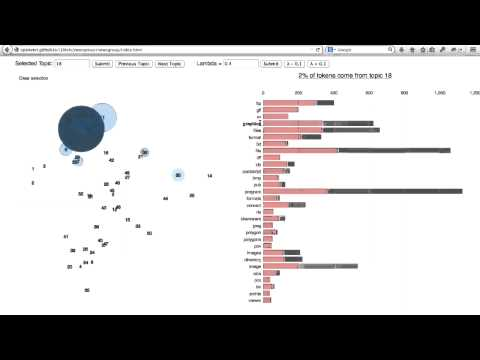

In [93]:
YouTubeVideo('IksL96ls4o0', width=800, height=400)

## Visdom

Install it with:

`conda install visdom`

Start the server:

`python -m visdom.server`

Visdom now can be accessed at http://localhost:8097 in the browser.


##### METRICS:
**DiffMetric** calculates the distance between two LDA models. This distance is calculated based on the topics, by either using their probability distribution over vocabulary words (**kullback_leibler**, hellinger) or by simply using the common vocabulary words between the topics from both model.

In the heatmap, X-axis define the Epoch no. and Y-axis define the distance between identical topics from consecutive epochs. For ex. a particular cell in the heatmap with values (x=3, y=5, z=0.4) represent the distance(=0.4) between the topic 5 from 3rd epoch and topic 5 from 2nd epoch. With increasing epochs, the distance between the identical topics should decrease.

SOURCE: 
- [LDA Training Visualization](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/Training_visualizations.ipynb)
- [Visdom](https://github.com/facebookresearch/visdom)
- [Training and Topic visualizations in gensim](https://rare-technologies.com/paruls-gsoc-2017-summary-training-and-topic-visualizations-in-gensim/)
- [OptimizingSemanticCoherenceinTopicModels](https://people.cs.umass.edu/~wallach/publications/mimno11optimizing.pdf)

In [ ]:
from gensim.models.callbacks import DiffMetric
from gensim.models.callbacks import CoherenceMetric

# define kullback_leibler callback
diff_kl = DiffMetric(distance="kullback_leibler", logger="visdom", title="kullback_leibler")
hellinger = DiffMetric(distance="hellinger", logger="visdom", title="hellinger")
jaccard = DiffMetric(distance="jaccard", logger="visdom", title="jaccard")


# training LDA model
ldamodel = LdaModel(
      tfidf_vect
    , num_topics=20
    , id2word=dictionary
    , passes=180
    , callbacks=[diff_kl, hellinger, jaccard]
)

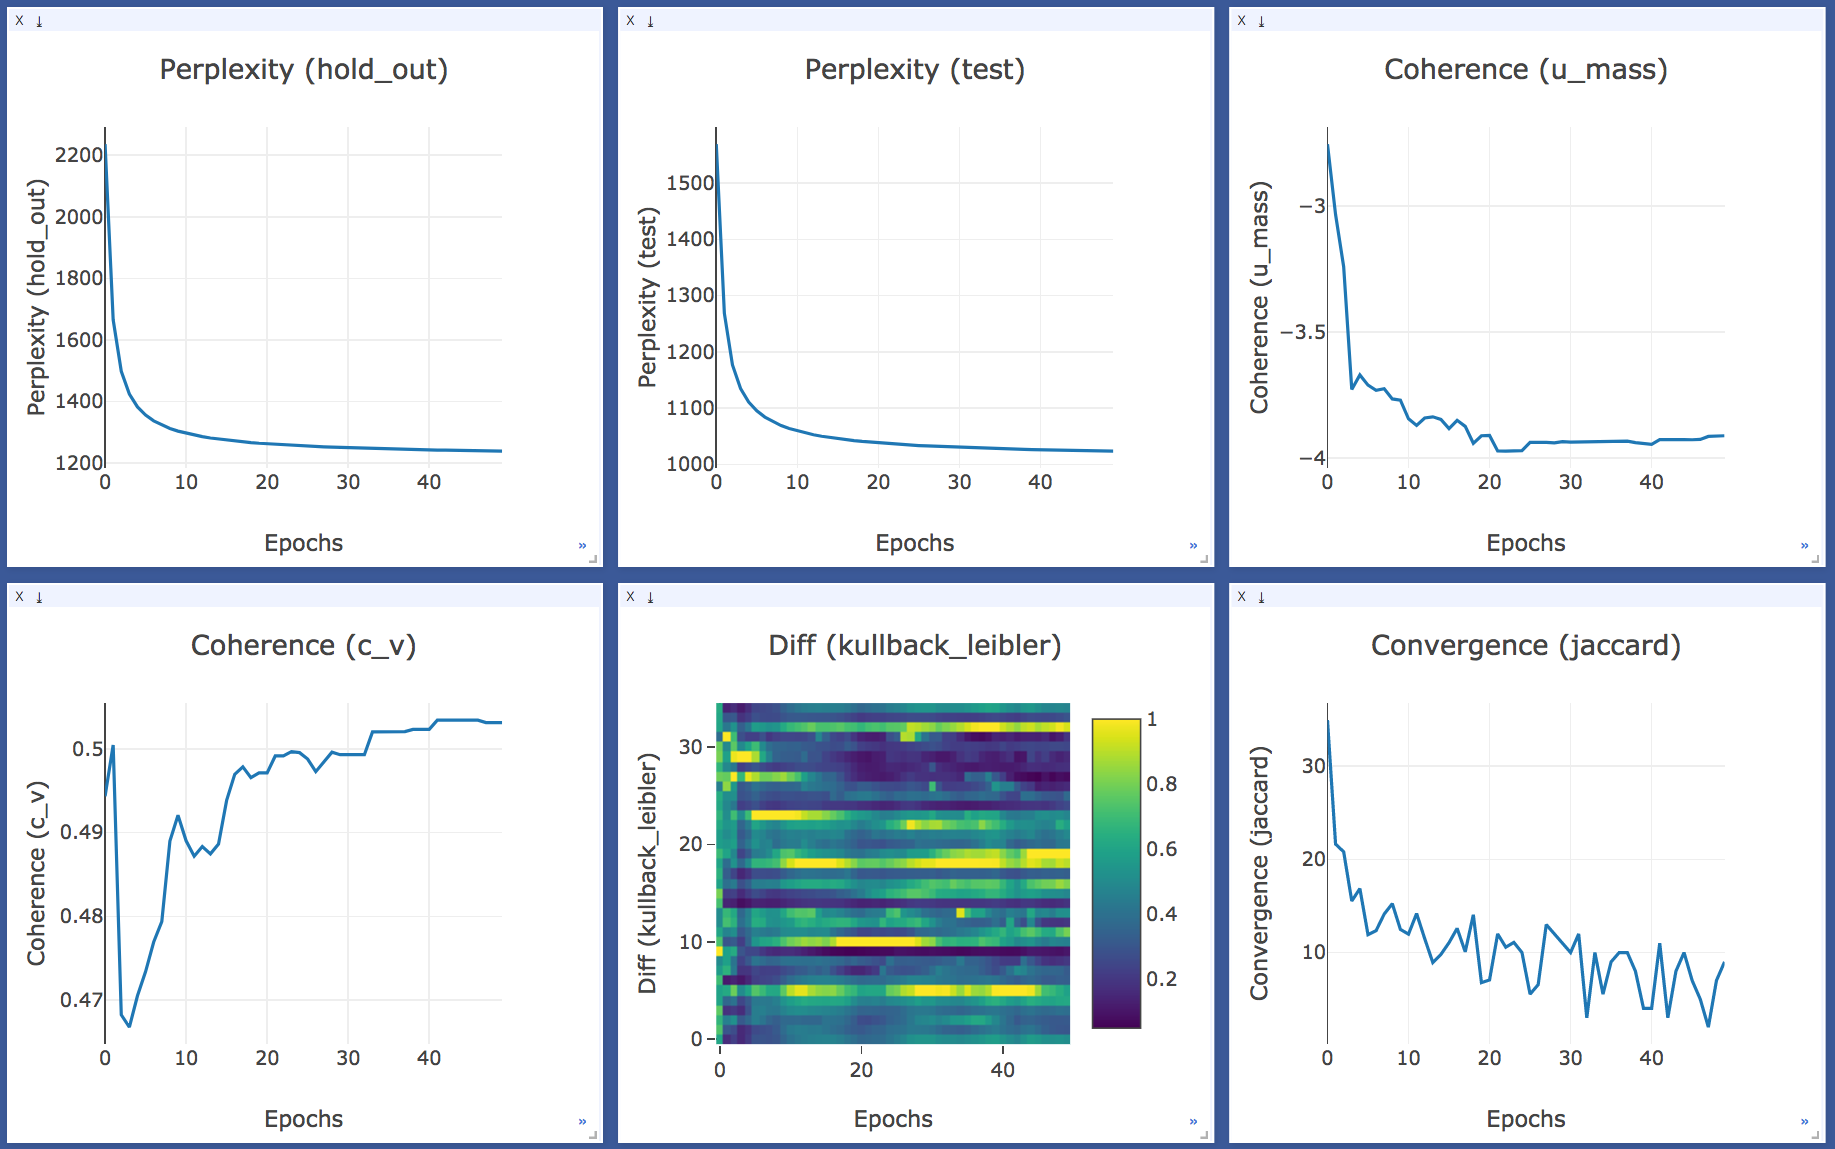

In [57]:
# visdom UI
Image("../../raw_data/images/visdom_graph.png", width=800)